In [1]:
'''
Import necessary libraries
'''
import numpy as np 
import pandas as pd
import os
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE
import math

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.models as models
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.utils as vutils
import torch.optim as optim
from torchinfo import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
networks = {
    'cerebellum': 18,
    'cingulo-opercular':32,
    'default_mode':34,
    'frontoparietal':21,
    'occipital': 22,
    'sensorimotor':33
}
# HYPERPARAMETERS

PRETRAINED = False
NETWORK = 'cerebellum'
ROIS = networks[NETWORK]
SEED = 6
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.2
OPTIMIZER = 'Adam'
DATASET_PATH = f'/kaggle/input/fmri-analysis/ACF/{NETWORK}'
PRETRAINED_MODEL_PATH = '/kaggle/working/autoencoder.pt'
NUM_EPOCHS = 1000
EMBEDDING_CHANNELS = 1

In [3]:
def show(data1, data2):
    '''function to visually compare the reconstructed image with the input images
    Each subject is represented by 2 rows and each pair of column corresponds to a ROI
    We can centre Crop the images before feeding to the Autoencoder (Custom Dataset)to get rid of the yellow border ,,
    '''

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))

    for i in range(0, 2):
        for j in range(0, 10, 2):
            ax1 = axes[i][j]
            channel1 = data1[i * 5 + j]
            ax1.imshow(channel1, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax1.axis('off')
            ax1.set_title('original')

            ax2 = axes[i][j + 1]
            channel2 = data2[i * 5 + (j // 2)]
            ax2.imshow(channel2, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax2.axis('off')
            ax2.set_title('reconstructed')

    plt.show()

In [4]:
class AutoEncoderDataset(Dataset):
    '''
    Dataset class AutoEncoderDataset get's the resized recurrence and stacks the singel channel image to make the input as a multichannel image 
    ROIi corresponds to ith channel in all datapoints
    '''
    def __init__(self, root_dir, in_num_channels, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.labels = []

        self.samples = []
        label_dict = {'healthy': 0, 'mci': 1}

        for class_name in ['healthy', 'mci']:
            class_dir = os.path.join(root_dir, class_name)

            for file_name in os.listdir(class_dir):
                if file_name.endswith("14state.png"):
                    paths = [os.path.join(class_dir, file_name.replace("14state.png", f"{i}state.png")) for i in range(1,in_num_channels+1)]
                    if all(os.path.exists(path) for path in paths):
                        label = os.path.join(class_dir, file_name.replace("14state.png", "state"))
                        new_label = (label.split('/')[-2],label.split('/')[-1][:-9])
                        self.samples.append((paths, new_label))
                        self.labels.append(new_label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        images = []

        for path in paths:
            image = Image.open(path)
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.CenterCrop((225,224)),
                transforms.Lambda(lambda img: img.crop((0, 0, img.width, img.height - 1))),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
            image_tensor = transform(image)
            images.append(image_tensor)
            
        combined_image = torch.stack(images, dim=1).squeeze()

        if self.transform:
            image = self.transform(combined_image)
        else:
            image = combined_image
        return image, label

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, rois, emb_channels):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # rois x 224 x 224
            nn.Conv2d(rois, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            # 64 x 112 x 112
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            # 128 x 56 x 56
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            # 256 x 28 x 28
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            # 512 x 28 x 28
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(1024, emb_channels, kernel_size=3, padding=1),
            nn.ReLU(),
#             nn.BatchNorm2d(emb_channels),
            nn.Dropout(0.25),
        )

        self.decoder = nn.Sequential(
            # 1024 x 14 x 14
            nn.ConvTranspose2d(emb_channels, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # 512 x 28 x 28
            nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # 256 x 28 x 28
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # 128 x 56 x 56
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # 64 x 112 x 112
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, rois, kernel_size=3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        x = self.encoder(x)
        bottleneck_output = self.bottleneck(x)
        x = self.decoder(bottleneck_output)
        return x, bottleneck_output

In [6]:
autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
summary(autoencoder_model, input_size=(BATCH_SIZE,ROIS,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [16, 18, 224, 224]        --
├─Sequential: 1-1                        [16, 1024, 14, 14]        --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        10,432
│    └─ReLU: 2-2                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [16, 64, 224, 224]        128
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─ReLU: 2-5                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-6                  [16, 64, 224, 224]        128
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─ReLU: 2-9                         [16, 128, 112, 112]       --
│    └─BatchNorm2d: 2-10                 [16, 128, 112, 112]       256
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147

In [7]:
def gaussian(window_size, sigma):
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

window = create_window(11, 1)

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

In [8]:
torch.manual_seed(SEED)

#%%%%%%%%%%%%%%%%%%%%%%%     DATASET CREATION   %%%%%%%%%%%%%%%%%%%%%%%
custom_dataset = AutoEncoderDataset(root_dir=DATASET_PATH, in_num_channels=ROIS)
val_size = int(len(custom_dataset) * TRAIN_TEST_SPLIT)
train_size = len(custom_dataset) - val_size
train_ds, val_ds = random_split(custom_dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

if PRETRAINED :
    #%%%%%%%%%%%%%%%%%%%%%%%     PRE TRAINED MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder_model = autoencoder_model.to(device)
    state_dict = torch.load(PRETRAINED_MODEL_PATH)
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = value

    autoencoder_model.load_state_dict(new_state_dict)
    autoencoder_model = DataParallel(autoencoder_model)
    criterion = nn.MSELoss()
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
else :
    # #%%%%%%%%%%%%%%%%%%%%%%%     MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder_model = autoencoder_model.to(device)
    autoencoder_model = DataParallel(autoencoder_model)
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
    #%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        autoencoder_model.train()
        train_loss = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = autoencoder_model(inputs)
            loss = 1 - ssim(outputs[0], inputs, val_range=255)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        autoencoder_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs = inputs.to(device)
                outputs = autoencoder_model(inputs)
                loss = 1 - ssim(outputs[0], inputs, val_range=255)
                val_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.5f} Val Loss: {val_loss:.5f}")

    torch.save(autoencoder_model.state_dict(), f'{NETWORK}_autoencoder.pt')

Epoch [5/1000]: Train Loss: 4.81216 Val Loss: 1.93993
Epoch [10/1000]: Train Loss: 4.78669 Val Loss: 1.90786
Epoch [15/1000]: Train Loss: 4.77109 Val Loss: 1.90825
Epoch [20/1000]: Train Loss: 4.74767 Val Loss: 1.89991
Epoch [25/1000]: Train Loss: 4.74238 Val Loss: 1.89712
Epoch [30/1000]: Train Loss: 4.73392 Val Loss: 1.89618
Epoch [35/1000]: Train Loss: 4.72642 Val Loss: 1.89762
Epoch [40/1000]: Train Loss: 4.71817 Val Loss: 1.89902
Epoch [45/1000]: Train Loss: 4.70569 Val Loss: 1.89510
Epoch [50/1000]: Train Loss: 4.68645 Val Loss: 1.89430
Epoch [55/1000]: Train Loss: 4.66080 Val Loss: 1.89331
Epoch [60/1000]: Train Loss: 4.63687 Val Loss: 1.89555
Epoch [65/1000]: Train Loss: 4.63212 Val Loss: 1.89862
Epoch [70/1000]: Train Loss: 4.58749 Val Loss: 1.88769
Epoch [75/1000]: Train Loss: 4.55105 Val Loss: 1.89293
Epoch [80/1000]: Train Loss: 4.53458 Val Loss: 1.88750
Epoch [85/1000]: Train Loss: 4.49646 Val Loss: 1.88672
Epoch [90/1000]: Train Loss: 4.47327 Val Loss: 1.88593
Epoch [95/1

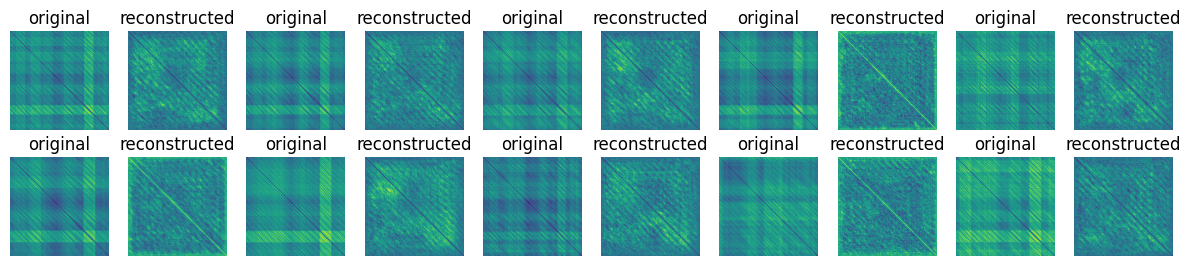

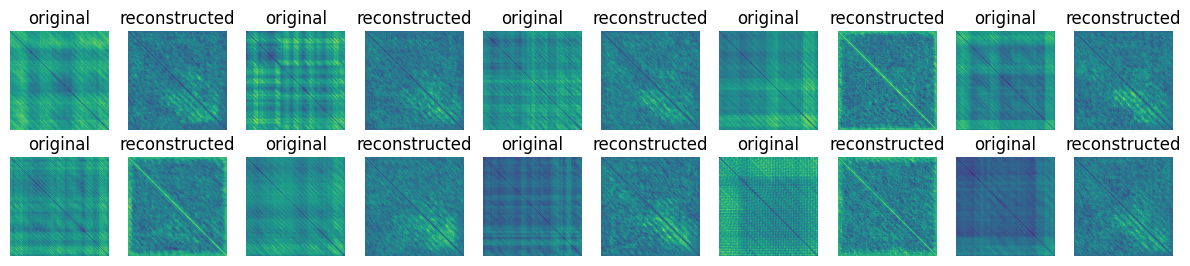

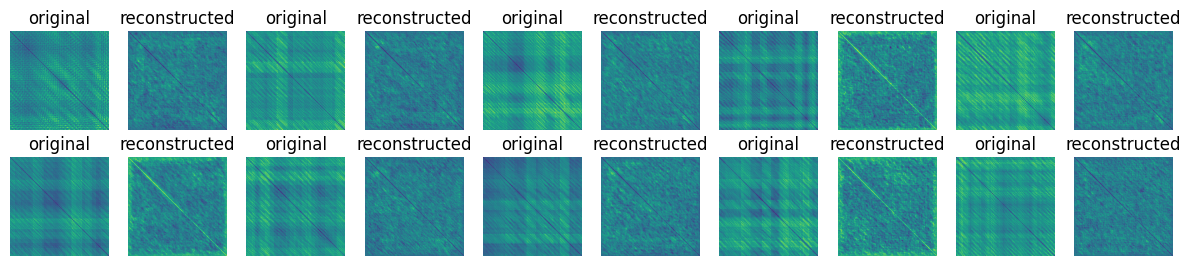

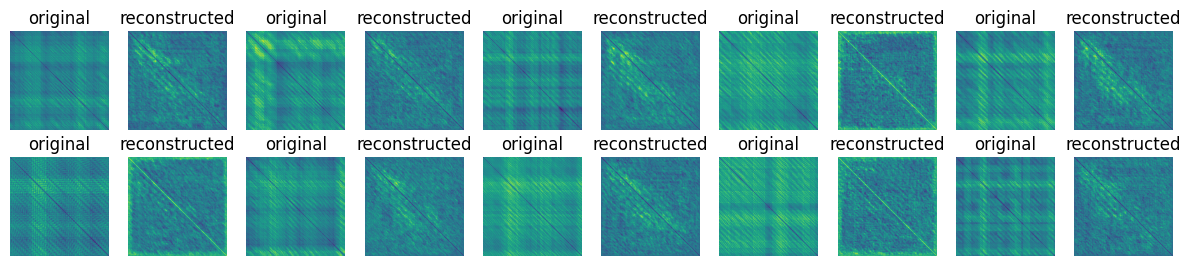

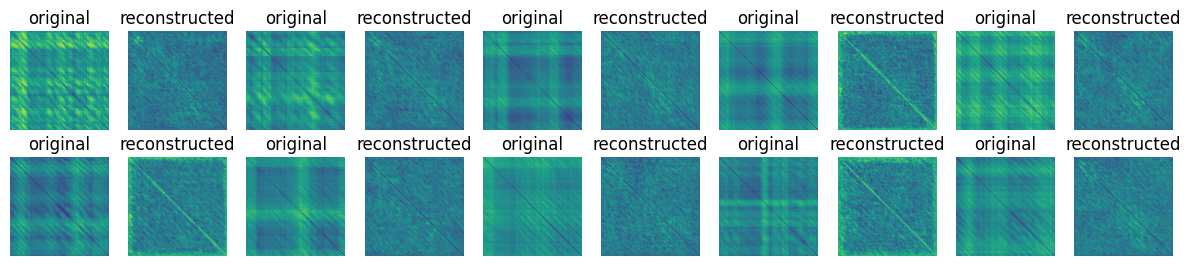

In [9]:
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(device)
        outputs = autoencoder_model(inputs)
        for k in range(5):
            show(inputs[k].to('cpu').numpy(), outputs[0][k].to('cpu').numpy())
        break

In [10]:
embedded_data = {'healthy':{}, 'mci':{}}
embedding_dataset = AutoEncoderDataset(root_dir=DATASET_PATH, in_num_channels=ROIS)
embedding_dl = DataLoader(embedding_dataset, batch_size=BATCH_SIZE)

In [11]:
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in embedding_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            subj_no = int(subj[-2:])
            if subj_no < 0 :
                embedded_data[class_][subj_no*(-1)] = embedding[k].cpu().numpy()
            else:
                embedded_data[class_][subj_no] = embedding[k].cpu().numpy()

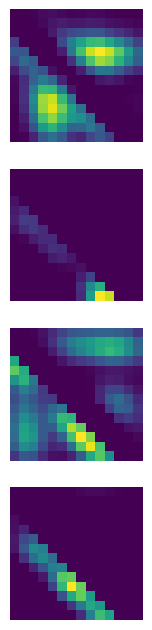

In [12]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        plt.imshow(embedded_data['healthy'][i][channel])
        plt.axis('off')
plt.show()

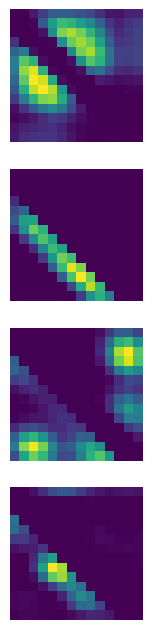

In [13]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        plt.imshow(embedded_data['mci'][i][channel])
        plt.axis('off')
plt.show()

In [14]:
class EmbeddedDataset(Dataset):
    '''Dataset class for classifying the latent space representation
    '''
    def __init__(self, class1_dict, class2_dict):
        self.class1_data = list(class1_dict.values())
        self.class2_data = list(class2_dict.values())
        self.class1_labels = [0] * len(self.class1_data)
        self.class2_labels = [1] * len(self.class2_data)
        self.data = self.class1_data + self.class2_data
        self.labels = self.class1_labels + self.class2_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = torch.Tensor(self.data[index])
        label = self.labels[index]
        return data, label

emb_data = EmbeddedDataset(embedded_data['healthy'], embedded_data['mci'])
val_size = int(len(emb_data) * 0.15)
train_size = len(emb_data) - val_size
train_ds, val_ds = random_split(emb_data, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=8)
val_dl = DataLoader(val_ds, batch_size=8)

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            # input 1 x 14 x 14
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Two output classes for binary classification
        )

    def forward(self, x):
        return self.model(x)

In [16]:
classfier_model = SimpleCNN(EMBEDDING_CHANNELS)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = classfier_model.to(device)
model = DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer_type = 'Adam'
learning_rate = 5e-4

if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100

#%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
train_losses = []
val_losses = []
train_accu = []
val_accu = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loss += loss.item()
    train_accuracy = 100 * train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # Accumulate validation loss

            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_dl)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accu.append(train_accuracy)
    val_accu.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/100]: Train Loss: 8.2434, Train Accuracy: 40.00%, Val Loss: 0.7044, Val Accuracy: 53.33%
Epoch [2/100]: Train Loss: 7.6516, Train Accuracy: 49.41%, Val Loss: 0.6929, Val Accuracy: 53.33%
Epoch [3/100]: Train Loss: 7.5926, Train Accuracy: 49.41%, Val Loss: 0.6918, Val Accuracy: 53.33%
Epoch [4/100]: Train Loss: 7.4557, Train Accuracy: 57.65%, Val Loss: 0.6832, Val Accuracy: 60.00%
Epoch [5/100]: Train Loss: 7.1997, Train Accuracy: 63.53%, Val Loss: 0.6914, Val Accuracy: 60.00%
Epoch [6/100]: Train Loss: 6.6586, Train Accuracy: 64.71%, Val Loss: 0.6603, Val Accuracy: 60.00%
Epoch [7/100]: Train Loss: 5.3171, Train Accuracy: 78.82%, Val Loss: 0.7891, Val Accuracy: 53.33%
Epoch [8/100]: Train Loss: 5.4300, Train Accuracy: 81.18%, Val Loss: 0.5770, Val Accuracy: 66.67%
Epoch [9/100]: Train Loss: 3.6824, Train Accuracy: 92.94%, Val Loss: 1.1619, Val Accuracy: 66.67%
Epoch [10/100]: Train Loss: 4.4180, Train Accuracy: 85.88%, Val Loss: 0.6317, Val Accuracy: 66.67%
Epoch [11/100]: Tra

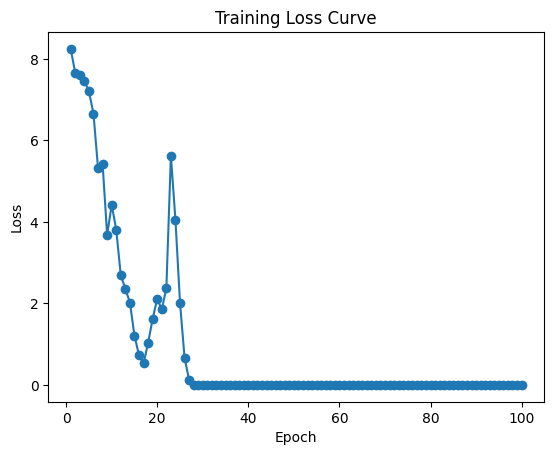

In [17]:
epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

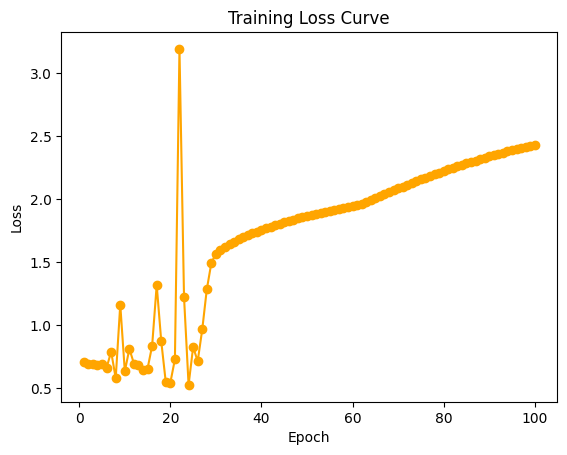

In [18]:
plt.plot(epochs, val_losses, marker='o', color = 'orange')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

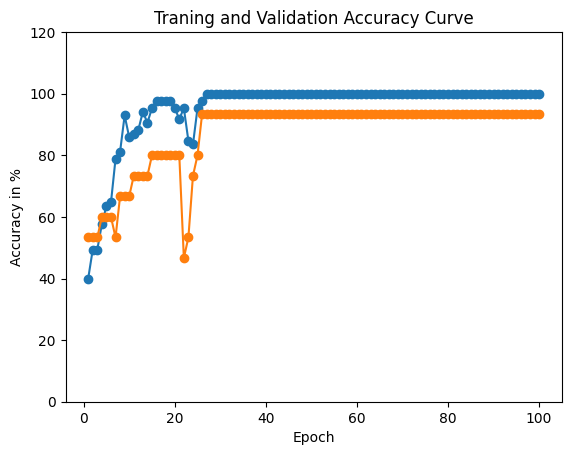

In [19]:
plt.plot(epochs, train_accu, marker='o')
plt.plot(epochs, val_accu, marker='o')
plt.title('Traning and Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy in %')
plt.ylim(0,120)
plt.show()

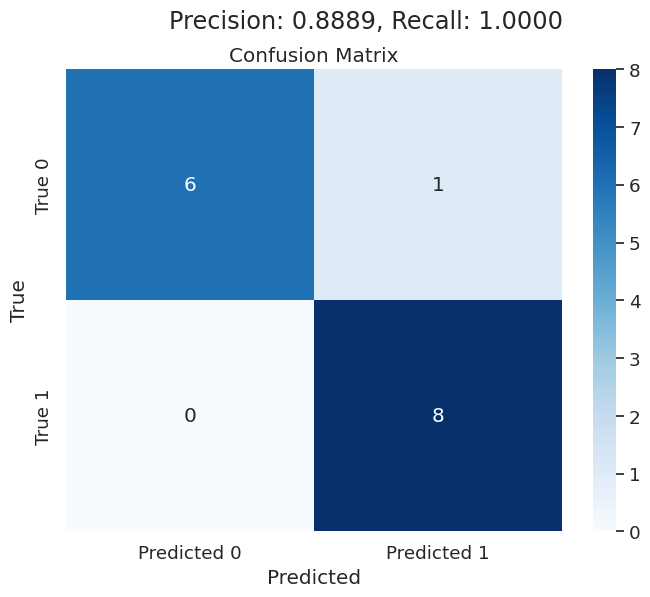

In [20]:
num_classes = 2  
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

model.eval()

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Convert to int (0 or 1)

        conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=[0, 1])


TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.suptitle(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
plt.show()